# Multigrid method 

This notebook describes how to use the multigrid method and how to add masks and all.

This is still an early version of the code and it ma evolve in the future, or there may be some additions to make this process smoother and easier.

I recommend working on a copy of that file.

### Install

in a fresh conda environment, first install the following dependencies:
```shell
conda install -c conda-forge matplotlib numpy ipympl cmcrameri pybind11
```

Then you also need a `c++` compiler, I tested this with clang 12, which you can install via `conda install -c conda-forge clang`. 

Once you do have all of these dependencies ready, you can run `python setup.py install` in this repository to install the package. Be careful it will install it in the current python environment (probably the anaconda one then?).

Note that you can also run the command `python setup.py build` to build a local version of the package into the `build` directory. While I have not tested it, it theoretically provide an importable package. The thing I am not sure is how it handle dependencies (i.e. you might be able to import the `.so` on your laptop, but another linux might need specific thing installed. I don't actually know.)

In [1]:
# This cell imports the required modules

import cppwtt as wt
import matplotlib
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import numpy as np
import time

%matplotlib widget

## Parametrisation

### Geometrical parameters:

- `nx,ny` are respectively the original number of columns and rows. The lower you start, the more qiucker the first steps will be. (minimum 8). they will be doubled at each doubling iterations
- `dx,dy` are the original spacings in x/y. They will be halved at each doubling iterations
- `lx,ly` are the original length
- `boundaries` manage in-built boundary conditions: "4edges", "periodic_NS" and "periodic_EW". If you are planning internal boundaries from mask, it does not matter.
- `nrefining` sets the number of refining iterations, i.e. the number of time the topography get more accurate
- `n_equ` sets the number of iterations in each level of otpimisation (equilibrates the divides). Higher = slower but better quality.

### Process parameters

- `tm,tn`: the m and n exponents of the stream power law. Usually the ratio m/n is between 0.2 and 0.8, median around 0.45.
- `tKref`: the erodibility ("the rock strength"). Lower values = higher relief. its magnitude varies between 1e-2 and 1e-13 and highly depends on the values of m and n. It ultimately controls the height of a mountain range.
- `tAcrit`: controls the transition between fluvial and hillslope processes by applying a threshold of drainage area (number of accumulated pixels draining to a single one times the area of a cell). Set to 1 if you only want fluvial landscapes, set to high values for a lot of linear hillslopes
- `tS_c`: critical slope of the hillslopes

In [35]:
# Original dimensions
nx,ny = 8,8
dx,dy = 1000,1000
lx,ly = (nx) * dx, (ny) * dy
boundaries = "4edges"
nrefining = 7
n_equ = 4

# Homogeneous values 
tm,tn = 0.45,1
tKref = 2e-5
tAcrit = 1e4
tS_c = 0.6

# Initialising the model
model = wt.MiniLEM()
## Sets the dimensions of the regular grid
model.initialise_graph(nx,ny,dx,dy,boundaries)
## initialise white noise
model.init_topo(1, "white_noise")
## feeds param to the model
model.set_uniform_parameters(tm, tn, tKref, tAcrit, tS_c, 5 )
model.set_hillslope_mode("critical_slope") # critical_slope


## Optional masking

The following cell is optional: it prepares a masking function that determines if/where to put a mask. In my case, this is a simple function that applies a mask I am defining from cusom coordinate (very arbitrary). this is where you will need to code something that translate your mask to it. It just need to return a bool array of dem dimensions.

- `init_boundaries_from_binary_array` takes that array (`.ravel()` vectorises it) and apply the boundaries while
- `burn_data_to_base_levels` burns the topographic data (here generated from sin waves, you can ignore that part) onto the boundaries.

This is activated into the code by switching the `apply_masking` function. It **needs** model as an input. if you add more params to this function, you'll need to change the call in the cell running the model.

In [36]:
apply_masking = False

def masking(model):
    dims = model.graph.get_dimensions()
    mask = np.zeros((dims['ny'], dims['nx']), dtype = bool)
    # adding a square
    mask[round(dims['ny']/4):2*round(dims['ny']/4), round(dims['ny']/4):2*round(dims['ny']/4)] = True
    # adding another square
    mask[round(3*dims['ny']/7):5*round(dims['ny']/7), round(3*dims['ny']/7):5*round(dims['ny']/7)] = True
    model.init_boundaries_from_binary_array(mask.ravel(), True)
    
    # adding random boundary from a sin cos wave
    x = np.linspace(dims['extents'][0],dims['extents'][1], dims['nx'])
    y = np.linspace(dims['extents'][2],dims['extents'][3], dims['ny'])
    xx,yy = np.meshgrid(x,y)
    preexisting_topo = np.abs(50 * np.sin(xx) * np.cos(yy))
    model.burn_data_to_base_levels(preexisting_topo.ravel())


## Running the model

The cell bellow runs a normal model run with the above parameters. Note the optional bluring function I commented at the end of the cell. This can apply fast gaussian blurring, O(n) unconditional to which window size is used is used.

In [37]:
start = time.time()
topos = []
for j in range(nrefining):
    for i in range(50 if (j == 0) else n_equ):
        model.solve_analytically()
    model.double_resolution() if(j < nrefining -1 ) else 0
    # model.init_circle_boundaries(lx/2,ly/2,0.9*lx/2,-1) if(j < nrefining -1 ) else 0
    model.graph.set_boundaries_to(0) if(j < nrefining -1 ) else 0
    # Only apply the masking if needed
    masking(model) if apply_masking else 0
    model.add_noise(20) if(j < nrefining -1 ) else 0

# model.blur(5) 
dims = model.graph.get_dimensions()

print("took", time.time() - start, 'for last res', dims['ny'] , "*", dims['nx'])



took 0.623694896697998 for last res 512 * 512


## Extracting info from the model

What you need is probably the topographic data and its dimensions.

Bellow, `dims` is a dictionnary with all the dimensions: nx,ny,dx,dy and extra ones: `nnodes` is simply nx * ny and `extent` is the bounding box I use for `matplotlib.pyplot.imshow` functions (xmin,xmax,ymin,ymax).

`topo` is the heightmap (DEM). It comes out as a 1D vector and needs reshaping for 2D plotting/saving. Note that we reshape with `ny,nx` (rows and cols). `HS` is simply the hillshaded topography.

In [38]:
dims = model.graph.get_dimensions()
topo = model.graph.get_topo_np()
topo = topo.reshape(dims['ny'],dims['nx'])
HS = np.array(model.graph.get_HS())
HS = HS.reshape(dims["ny"],dims["nx"])


Text(0, 0.5, 'Northing (m)')

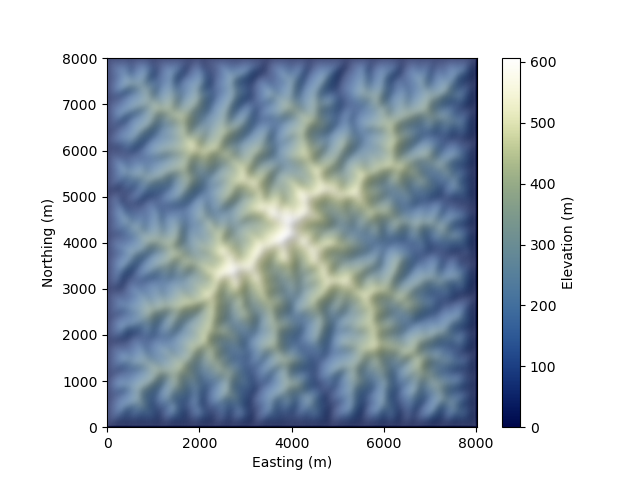

In [39]:
fig,ax = plt.subplots()
cb = ax.imshow(topo, extent = dims["extents"], cmap = cm.davos)
ax.imshow(HS, extent = dims["extents"], cmap = cm.grayC_r, alpha = 0.35)
plt.colorbar(cb, label = "Elevation (m)")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

## Normalising Elevation

To reach a target median elevation, you can either adjust K or simply normalise elevation. You can normalise by median, mean, max, percentile ... depending on your need

In [21]:
tg_elev = 200
topo = topo/np.median(topo) * tg_elev

Text(0, 0.5, 'Northing (m)')

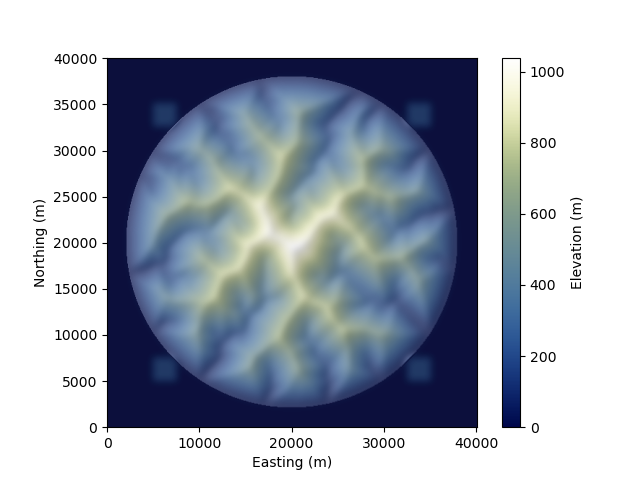

In [22]:
fig,ax = plt.subplots()
cb = ax.imshow(topo, extent = dims["extents"], cmap = cm.davos)
ax.imshow(HS, extent = dims["extents"], cmap = cm.grayC_r, alpha = 0.35)
plt.colorbar(cb, label = "Elevation (m)")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

# Saving to DEM

You may need to save the output to a DEM. To do so you need extra dependencies. I am using `rasterio` which itself uses `gdal`. Note that I am saving it to a random WGS84 UTM zone but you can adjust that with your own projection.

`conda install -c conda-forge rasterio`

In [23]:
import pywtt as ptt

ptt.raster_loader.save_raster(topo,dims['extents'][0],dims['extents'][1],dims['extents'][2],dims['extents'][3],dims['dx'], 'EPSG:32631',fname = "mydem.tif", fmt = 'GTIFF')